In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
from pathlib import Path
from time import time
from copy import deepcopy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
ROOT_PATH = Path().absolute().parent.parent
if str(ROOT_PATH) not in sys.path:
    sys.path.insert(1, str(ROOT_PATH))
from frequency_response import FrequencyResponse
from legacy_frequency_response import LegacyFrequencyResponse
from peq import PEQ, OptimizationHistory, OptimizationFinished
from constants import DEFAULT_FS, PEQ_CONFIGS

In [7]:
def plot_loss(time, loss, avg, std, fig=None, ax=None):
    time = np.array(time)
    loss = np.array(loss)
    if fig is None:
        fig, ax = plt.subplots()
        fig.set_size_inches(15, 8)
    ax.minorticks_on()
    ax.grid(which='both')
    ax.set_ylabel('dB')
    ax.set_xlabel('Time (s)')
    ax.plot(time, loss, '-o', label='Loss')
    ix = np.argmax(avg != 0.0)
    ix = 0
    ax.plot(time[ix:], avg[ix:], '-o', label='Avg')
    ax.plot(time[ix:], std[ix:], '-o', label='STD')
    ax.legend()
    return fig, ax

In [8]:
def rmse(fr, eq):
    ix10k = np.argmin(np.abs(10000 - fr.frequency))
    return np.sqrt(np.mean(np.square(fr.equalization[:ix10k] - eq[:ix10k])))

In [9]:
def extend_config(config, **optimizer_kwargs):
    config2 = deepcopy(config)
    if 'optimizer' not in config2:
        config2['optimizer'] = dict(**optimizer_kwargs)
    else:
        config2['optimizer'].update(dict(**optimizer_kwargs))
    return config2

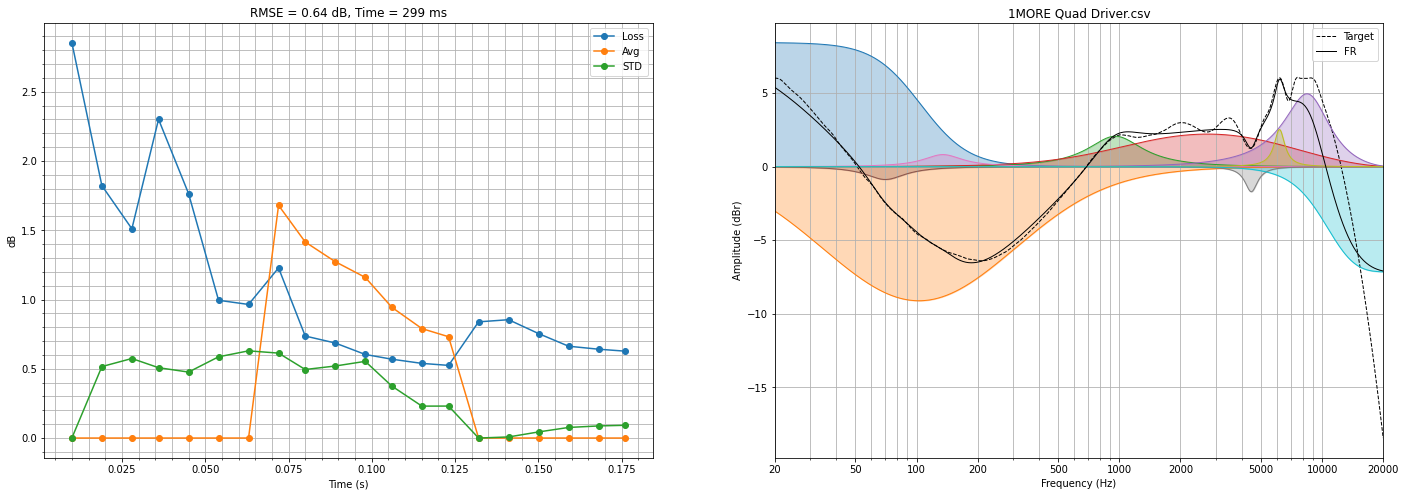

In [10]:
#configs = [PEQ_CONFIGS['4_PEAKING_WITH_LOW_SHELF']]
configs = [PEQ_CONFIGS['4_PEAKING_WITH_LOW_SHELF'], PEQ_CONFIGS['4_PEAKING_WITH_HIGH_SHELF']]
#configs = [PEQ_CONFIGS['8_PEAKING_WITH_SHELVES']]
#configs = [ PEQ_CONFIGS['10_PEAKING']]
configs = [extend_config(config) for config in configs]
df = []
n = 0
for fp in ROOT_PATH.joinpath('results', 'oratory1990').glob('*/*/*.csv'):
    fr = FrequencyResponse.read_from_csv(fp)
    peqs = fr.optimize_parametric_eq(configs, DEFAULT_FS, max_time=3)
    #peqs = fr.optimize_fixed_band_eq([extend_config(PEQ_CONFIGS['10_BAND_GRAPHIC_EQ'])], DEFAULT_FS, max_time=3)
    for i, peq in enumerate(peqs):
        if i > 0:
            peq.history.time = [x + peqs[i-1].history.time[-1] for x in peq.history.time]
    t = np.concatenate([peq.history.time for peq in peqs])
    loss = np.concatenate([peq.history.loss for peq in peqs])
    avg = np.concatenate([peq.history.moving_avg_loss for peq in peqs])
    std = np.concatenate([peq.history.std for peq in peqs])
    fig, axs = plt.subplots(1, 2)
    fig.set_size_inches(24, 8)
    plot_loss(t, loss, avg, std, fig=fig, ax=axs[0])
    if len(peqs) > 1:
        for i in range(1, len(peqs)):
            for filt in peqs[i].filters:
                peqs[0].add_filter(filt)
    FrequencyResponse.init_plot(fig=fig, ax=axs[1])
    peqs[0].plot(fig=fig, ax=axs[1])
    t = np.sum([peq.history.time[-1] for peq in peqs])
    err = rmse(fr, peqs[0].fr)
    axs[0].set_title(f'RMSE = {err:.2f} dB, Time = {t * 1000:.0f} ms')
    axs[1].set_title(f'{fp.name}')
    df.append({'time': t, 'rmse': err})
    plt.show()
    n += 1
    if n == 1:
        break
df = pd.DataFrame(df)

In [125]:
# 4 PK + LS, no extra early stopping
df.describe()

,time,rmse
count,30.000000,30.000000
mean,0.122236,0.586501
std,0.055361,0.185373
min,0.076749,0.190368
25%,0.093651,0.472436
50%,0.111397,0.548343
75%,0.135129,0.685112
max,0.368115,0.991042


In [127]:
# 4 PK + LS, extra early stopping
df.describe()

,time,rmse
count,30.000000,30.000000
mean,0.086572,0.617310
std,0.033912,0.201855
min,0.046010,0.206936
25%,0.062753,0.479643
50%,0.080026,0.567124
75%,0.101154,0.783709
max,0.172932,1.011043


In [129]:
# 4 PK + LS, 4 PK + HS, no extra early stopping
df.describe()

,time,rmse
count,30.000000,30.000000
mean,0.332923,0.305905
std,0.109492,0.083399
min,0.230530,0.144168
25%,0.269469,0.248429
50%,0.302706,0.286481
75%,0.357911,0.347185
max,0.817435,0.492567


In [131]:
# 4 PK + LS, 4 PK + HS, extra early stopping
df.describe()

,time,rmse
count,30.000000,30.000000
mean,0.227787,0.333322
std,0.068031,0.074536
min,0.142765,0.172989
25%,0.181310,0.300349
50%,0.213931,0.327855
75%,0.264133,0.354708
max,0.389181,0.527471


In [135]:
# 8 PK + LS + HS, no extra early stopping
df.describe()

,time,rmse
count,30.000000,30.000000
mean,0.528119,0.215964
std,0.087036,0.070110
min,0.380081,0.119471
25%,0.486780,0.159270
50%,0.513659,0.198705
75%,0.559168,0.263719
max,0.800819,0.390633


In [144]:
# 10 PK, no extra early stopping
df.describe()

,time,rmse
count,30.000000,30.000000
mean,0.609816,0.439734
std,0.217843,0.273624
min,0.326983,0.132029
25%,0.419980,0.267929
50%,0.582677,0.417672
75%,0.704602,0.513003
max,1.252063,1.378783


In [146]:
# 10 PK, extra early stopping
df.describe()

,time,rmse
count,30.000000,30.000000
mean,0.476823,0.497163
std,0.203088,0.282143
min,0.176439,0.146127
25%,0.327802,0.296893
50%,0.455539,0.458110
75%,0.561646,0.586951
max,1.068535,1.423631
